In [1]:
import numpy as np
import scipy
import sys
import os
import optuna

from sklearn.model_selection import train_test_split

from LSPIN_model import Model
from utils import convertToOneHot, DataSet

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

### Data Generation (Exp 4)

In [3]:
np.random.seed(34)
X1 = np.random.normal(loc=1,scale=0.5,size=(500,4))
X2 = np.random.normal(loc=-1,scale=0.5,size=(500,4))
logit1 = np.exp(X1[:, 0] *X1[:, 1]  - 0.9)
logit2 = np.exp(np.sum(X2[:, 2:4]**2, axis = 1) - 2.5)
Y1 = 1.*(1/(1+logit1) > 0.5).reshape(-1,1)
Y2 = 1.*(1/(1+logit2) > 0.5).reshape(-1,1)

In [4]:
#### add noise to the next 46 irrelevant features
X = np.concatenate((X1,X2),axis=0)
noise = np.random.normal(loc=0,scale=0.5,size=(1000,46))
X = np.concatenate((X,noise),axis=1)
Y = np.concatenate((Y1,Y2),axis=0).reshape(-1)

In [5]:
ground_truth = np.zeros((1000,50))
ground_truth[:500,:2] = 1
ground_truth[500:,2:4] = 1

In [6]:
Y_onehot = convertToOneHot(Y.astype(int))

In [7]:
y_g = np.concatenate((Y_onehot,ground_truth),axis=1)

In [8]:
X_non_zeros=np.sum(X,axis=0)!=0
XN=scipy.stats.zscore(X[:,X_non_zeros], axis=0)

In [9]:
x_train,x_test,y_g_train,y_g_test = train_test_split(XN,y_g,train_size=0.95,random_state=34)
x_train,x_valid,y_g_train,y_g_valid = train_test_split(x_train,y_g_train,test_size=0.1,random_state=34)

In [10]:
y_train = y_g_train[:,:2]
y_valid = y_g_valid[:,:2]
y_test = y_g_test[:,:2]

In [11]:
g_train = y_g_train[:,2:]
g_valid = y_g_valid[:,2:]
g_test = y_g_test[:,2:]

In [12]:
dataset = DataSet(**{'_data':x_train, '_labels':y_train,
                '_valid_data':x_valid, '_valid_labels':y_valid,
                '_test_data':x_test, '_test_labels':y_test})

### LSPIN

In [29]:
def lspin_objective(trial):  
    
    global model
            
    params = {
        "feature_selection" : True,
        "sigma" : 0.5,
        "display_step" : 200,
        "hidden_layers_node" : [200,200], # 2 hidden layers with 200 nodes each, output layer with 2 nodes
        "batch_normalization":False,
        "input_node" : x_train.shape[1],
        "output_node" : 2
    }
    params['stddev_input'] = 0.1
    params['activation']= 'tanh' 
    params['batch_size']= x_train.shape[0] 
    params['feature_selection_dimension']=[100,100] 
    
    params['lam'] = trial.suggest_loguniform('lam',1.33,1.35) 
    params['learning_rate'] = trial.suggest_loguniform('learning_rate',0.03,0.05) 
    num_epoch = trial.suggest_categorical('num_epoch', [1000,1200])

    model_dir = None
    model = Model(**params)
    train_acces, train_losses, val_acces, val_losses = model.train(trial, dataset, model_dir, num_epoch=num_epoch)
        
    print("In trial:---------------------")    
    loss=(1-val_acces[-1])
            
    return loss
        
def callback(study,trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

In [ ]:
best_model = None
model = None
study = optuna.create_study(pruner=None)
study.optimize(lspin_objective, n_trials=20, callbacks=[callback])

[I 2021-06-08 00:29:01,755] A new study created in memory with name: no-name-67b3a008-cff9-46b1-91c0-333c2615df72


num_samples : 855
Epoch: 200 train loss=1.416467667 valid loss= 1.452327609 valid acc= 0.736842096
train reg_fs: 0.9265543222427368
Epoch: 400 train loss=0.941349030 valid loss= 0.984793603 valid acc= 0.800000012
train reg_fs: 0.5744215846061707
Epoch: 600 train loss=0.659266472 valid loss= 0.642455161 valid acc= 0.905263186
train reg_fs: 0.3219015598297119
Epoch: 800 train loss=0.631370425 valid loss= 0.564956188 valid acc= 0.926315784
train reg_fs: 0.2834206223487854


[I 2021-06-08 00:29:05,365] Trial 0 finished with value: 0.0736842155456543 and parameters: {'lam': 1.3374961577277336, 'learning_rate': 0.039125347904239695, 'num_epoch': 1000}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1000 train loss=0.572798193 valid loss= 0.544017792 valid acc= 0.926315784
train reg_fs: 0.2716415822505951
Optimization Finished!
test loss: 0.5796085596084595, test acc: 0.8999999761581421
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.483689189 valid loss= 1.474424362 valid acc= 0.800000012
train reg_fs: 0.9637041091918945
Epoch: 400 train loss=1.142046452 valid loss= 1.123273849 valid acc= 0.842105269
train reg_fs: 0.7258409857749939
Epoch: 600 train loss=0.745460153 valid loss= 0.736205220 valid acc= 0.873684227
train reg_fs: 0.39548659324645996
Epoch: 800 train loss=0.644355416 valid loss= 0.605786860 valid acc= 0.915789485
train reg_fs: 0.30288082361221313
Epoch: 1000 train loss=0.599882364 valid loss= 0.576349854 valid acc= 0.915789485
train reg_fs: 0.2816104292869568


[I 2021-06-08 00:29:09,916] Trial 1 finished with value: 0.10526317358016968 and parameters: {'lam': 1.3383992772099278, 'learning_rate': 0.033124269931764046, 'num_epoch': 1200}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1200 train loss=0.618317008 valid loss= 0.580404282 valid acc= 0.894736826
train reg_fs: 0.2728283703327179
Optimization Finished!
test loss: 0.5438217520713806, test acc: 0.8999999761581421
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.402539372 valid loss= 1.443993807 valid acc= 0.726315796
train reg_fs: 0.9300333857536316
Epoch: 400 train loss=0.949195981 valid loss= 0.941356421 valid acc= 0.831578970
train reg_fs: 0.5623534917831421
Epoch: 600 train loss=0.661354423 valid loss= 0.628169537 valid acc= 0.905263186
train reg_fs: 0.3201603889465332
Epoch: 800 train loss=0.612373114 valid loss= 0.555624485 valid acc= 0.926315784
train reg_fs: 0.2840861976146698


[I 2021-06-08 00:29:13,840] Trial 2 finished with value: 0.10526317358016968 and parameters: {'lam': 1.3417890614922383, 'learning_rate': 0.03852459537855709, 'num_epoch': 1000}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1000 train loss=0.587790787 valid loss= 0.557670712 valid acc= 0.894736826
train reg_fs: 0.27223843336105347
Optimization Finished!
test loss: 0.5711503624916077, test acc: 0.9200000166893005
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.463373423 valid loss= 1.507778883 valid acc= 0.736842096
train reg_fs: 0.9655645489692688
Epoch: 400 train loss=1.097110391 valid loss= 1.158694267 valid acc= 0.800000012
train reg_fs: 0.7243036031723022
Epoch: 600 train loss=0.734652519 valid loss= 0.724450111 valid acc= 0.884210527
train reg_fs: 0.39097002148628235
Epoch: 800 train loss=0.637453556 valid loss= 0.596585393 valid acc= 0.905263186
train reg_fs: 0.3040172755718231
Epoch: 1000 train loss=0.614132345 valid loss= 0.555091143 valid acc= 0.915789485
train reg_fs: 0.2835153043270111


[I 2021-06-08 00:29:18,029] Trial 3 finished with value: 0.08421051502227783 and parameters: {'lam': 1.3448563095173969, 'learning_rate': 0.03302256142183416, 'num_epoch': 1200}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1200 train loss=0.586758256 valid loss= 0.536130786 valid acc= 0.915789485
train reg_fs: 0.27511635422706604
Optimization Finished!
test loss: 0.565221905708313, test acc: 0.8799999952316284
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.483869076 valid loss= 1.472794056 valid acc= 0.736842096
train reg_fs: 0.9392780661582947
Epoch: 400 train loss=1.068114161 valid loss= 1.123670816 valid acc= 0.757894754
train reg_fs: 0.6376194953918457
Epoch: 600 train loss=0.736238539 valid loss= 0.775716066 valid acc= 0.800000012
train reg_fs: 0.32825854420661926
Epoch: 800 train loss=0.644231200 valid loss= 0.694290638 valid acc= 0.800000012
train reg_fs: 0.27382567524909973


[I 2021-06-08 00:29:21,632] Trial 4 finished with value: 0.21052628755569458 and parameters: {'lam': 1.3315710341938907, 'learning_rate': 0.04083764494115181, 'num_epoch': 1000}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1000 train loss=0.595821917 valid loss= 0.678827167 valid acc= 0.789473712
train reg_fs: 0.2592620253562927
Optimization Finished!
test loss: 0.7905731201171875, test acc: 0.7799999713897705
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.345761657 valid loss= 1.403322101 valid acc= 0.705263138
train reg_fs: 0.8873472809791565
Epoch: 400 train loss=0.787194073 valid loss= 0.799606621 valid acc= 0.831578970
train reg_fs: 0.43119919300079346
Epoch: 600 train loss=0.621084690 valid loss= 0.608158708 valid acc= 0.884210527
train reg_fs: 0.29483893513679504
Epoch: 800 train loss=0.578289092 valid loss= 0.575326324 valid acc= 0.905263186
train reg_fs: 0.27455005049705505
Epoch: 1000 train loss=0.557446480 valid loss= 0.564252734 valid acc= 0.905263186
train reg_fs: 0.26729318499565125


[I 2021-06-08 00:29:25,898] Trial 5 finished with value: 0.12631577253341675 and parameters: {'lam': 1.33569853729867, 'learning_rate': 0.047778368298536926, 'num_epoch': 1200}. Best is trial 0 with value: 0.0736842155456543.


Epoch: 1200 train loss=0.565387011 valid loss= 0.548272192 valid acc= 0.873684227
train reg_fs: 0.2631266713142395
Optimization Finished!
test loss: 0.5974491834640503, test acc: 0.8600000143051147
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.514051676 valid loss= 1.518829823 valid acc= 0.736842096
train reg_fs: 0.9526914358139038
Epoch: 400 train loss=1.096657038 valid loss= 1.118661642 valid acc= 0.800000012
train reg_fs: 0.6805540919303894
Epoch: 600 train loss=0.722850561 valid loss= 0.710948348 valid acc= 0.884210527
train reg_fs: 0.3720944821834564
Epoch: 800 train loss=0.633392811 valid loss= 0.589373410 valid acc= 0.915789485
train reg_fs: 0.2983720302581787
Epoch: 1000 train loss=0.610990047 valid loss= 0.554290712 valid acc= 0.915789485
train reg_fs: 0.28010761737823486


[I 2021-06-08 00:29:30,100] Trial 6 finished with value: 0.06315791606903076 and parameters: {'lam': 1.3423381427056187, 'learning_rate': 0.03188731746801261, 'num_epoch': 1200}. Best is trial 6 with value: 0.06315791606903076.


Epoch: 1200 train loss=0.608981192 valid loss= 0.532847762 valid acc= 0.936842084
train reg_fs: 0.2724672853946686
Optimization Finished!
test loss: 0.5878341197967529, test acc: 0.8799999952316284
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.336208344 valid loss= 1.319756389 valid acc= 0.810526311
train reg_fs: 0.8813821077346802
Epoch: 400 train loss=0.763393939 valid loss= 0.736794770 valid acc= 0.863157868
train reg_fs: 0.4048195779323578
Epoch: 600 train loss=0.618545651 valid loss= 0.578953981 valid acc= 0.926315784
train reg_fs: 0.29303571581840515
Epoch: 800 train loss=0.591875851 valid loss= 0.544848442 valid acc= 0.936842084
train reg_fs: 0.27521300315856934


[I 2021-06-08 00:29:33,725] Trial 7 finished with value: 0.0736842155456543 and parameters: {'lam': 1.3434716598340717, 'learning_rate': 0.046128525007909864, 'num_epoch': 1000}. Best is trial 6 with value: 0.06315791606903076.


Epoch: 1000 train loss=0.588497996 valid loss= 0.526928782 valid acc= 0.926315784
train reg_fs: 0.26797688007354736
Optimization Finished!
test loss: 0.6159058809280396, test acc: 0.8600000143051147
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.456729174 valid loss= 1.448524356 valid acc= 0.768421054
train reg_fs: 0.9530304074287415
Epoch: 400 train loss=1.078486085 valid loss= 1.078985453 valid acc= 0.831578970
train reg_fs: 0.6785131096839905
Epoch: 600 train loss=0.718863368 valid loss= 0.678034782 valid acc= 0.894736826
train reg_fs: 0.35740724205970764
Epoch: 800 train loss=0.636946917 valid loss= 0.586678743 valid acc= 0.905263186
train reg_fs: 0.29391661286354065
Epoch: 1000 train loss=0.590852380 valid loss= 0.574681461 valid acc= 0.894736826
train reg_fs: 0.27781441807746887


[I 2021-06-08 00:29:37,994] Trial 8 finished with value: 0.10526317358016968 and parameters: {'lam': 1.3348187210021076, 'learning_rate': 0.036342278103913835, 'num_epoch': 1200}. Best is trial 6 with value: 0.06315791606903076.


Epoch: 1200 train loss=0.568659425 valid loss= 0.572504520 valid acc= 0.894736826
train reg_fs: 0.2709316313266754
Optimization Finished!
test loss: 0.541104793548584, test acc: 0.9200000166893005
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.491554499 valid loss= 1.485374331 valid acc= 0.757894754
train reg_fs: 0.9729864001274109
Epoch: 400 train loss=1.153601289 valid loss= 1.144408822 valid acc= 0.852631569
train reg_fs: 0.754075825214386
Epoch: 600 train loss=0.788585186 valid loss= 0.743128538 valid acc= 0.884210527
train reg_fs: 0.4304160177707672
Epoch: 800 train loss=0.645650387 valid loss= 0.584874868 valid acc= 0.936842084
train reg_fs: 0.3135574460029602
Epoch: 1000 train loss=0.594952345 valid loss= 0.543522477 valid acc= 0.947368443
train reg_fs: 0.28651297092437744


[I 2021-06-08 00:29:42,146] Trial 9 finished with value: 0.05263155698776245 and parameters: {'lam': 1.3464888781514361, 'learning_rate': 0.03007005911406379, 'num_epoch': 1200}. Best is trial 9 with value: 0.05263155698776245.


Epoch: 1200 train loss=0.586553454 valid loss= 0.532837212 valid acc= 0.947368443
train reg_fs: 0.2765713930130005
Optimization Finished!
test loss: 0.5736778974533081, test acc: 0.8999999761581421
In trial:---------------------
num_samples : 855
Epoch: 200 train loss=1.420165062 valid loss= 1.474161744 valid acc= 0.694736838
train reg_fs: 0.9250065088272095
Epoch: 400 train loss=0.887501359 valid loss= 0.894874096 valid acc= 0.842105269
train reg_fs: 0.5209464430809021
Epoch: 600 train loss=0.646221459 valid loss= 0.615471125 valid acc= 0.926315784
train reg_fs: 0.3128178119659424
Epoch: 800 train loss=0.582800508 valid loss= 0.557396531 valid acc= 0.926315784
train reg_fs: 0.2830597460269928
Epoch: 1000 train loss=0.593126535 valid loss= 0.541274190 valid acc= 0.936842084
train reg_fs: 0.27299532294273376


In [15]:
gate_mat_nonl=best_model.get_prob_alpha(x_train)

In [16]:
best_lr = study.best_params['learning_rate']
best_epoch = study.best_params['num_epoch']
best_lam = study.best_params['lam']

test_acc, loss = best_model.evaluate(x_test,y_test)
            
print("Trial Finished*************")
print("Best model's lambda: {}".format(best_lam))
print("Best model's learning rate: {}".format(best_lr))
print("Best model's num of epochs: {}".format(best_epoch))
print("Test acc : {}".format(test_acc))

test loss: 0.4867679476737976, test acc: 0.9800000190734863
Saving model..
Trial Finished*************
Best model's lambda: 1.3418530420177768
Best model's learning rate: 0.030612651537454055
Best model's num of epochs: 1200
Test acc : 0.9800000190734863


### Comparing the training gates

In [21]:
from matplotlib import cm,colors
import matplotlib 
import matplotlib.pyplot as plt

cmap = cm.Blues 
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

title_size = 30
xlabel_size = 35
ylabel_size = 35
xtick_size = 20
ytick_size = 20
bar_label_size = 20

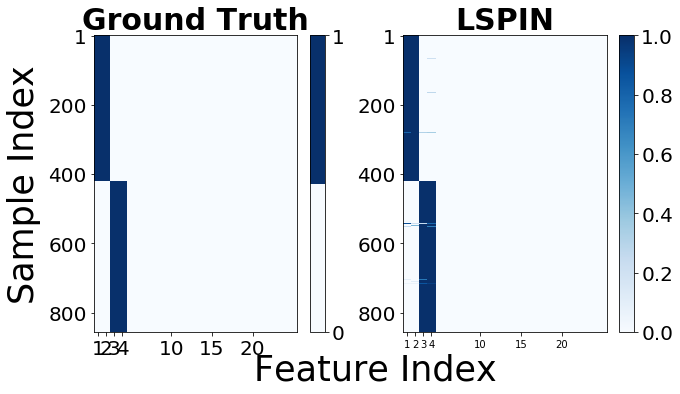

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True,sharey=False,figsize=(10,6))

fig.add_subplot(111, frameon=False)
matplotlib.rc('xtick', labelsize=xtick_size) 

g_train_label = 1*(g_train[:,2] == 1)
sorted_order_train = np.concatenate((np.where(g_train_label == 0)[0],np.where(g_train_label == 1)[0]))

im1 = axes[0].imshow(g_train[sorted_order_train,:25],aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold")
axes[0].set_xticks([0,1,2,3,9,14,19])
axes[0].set_xticklabels([1,2,3,4,10,15,20],fontsize=xtick_size)
axes[0].set_yticks([0,199,399,599,799])
axes[0].set_yticklabels([1,200,400,600,800],fontsize=ytick_size)
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size,labelpad=7)

im3 = axes[1].imshow(gate_mat_nonl[sorted_order_train,:25],aspect='auto',cmap=cmap)
axes[1].set_title("LSPIN",fontsize=title_size,fontweight="bold")
axes[1].set_yticks([0,199,399,599,799])
axes[1].set_yticklabels([1,200,400,600,800],fontsize=ytick_size)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)
cbar = fig.colorbar(im3,ax=axes[1])
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index",fontsize=xlabel_size)

plt.tight_layout()

In [23]:
### TPR of the discoveries
print("True Positive Rate: {:.4f}".format(np.sum((g_train > 0) & (gate_mat_nonl >0))/np.sum(g_train > 0)))

True Positive Rate: 0.9988


In [24]:
### FDR of the discoveries
print("False Discovery Rate: {:.4f}".format(np.sum((g_train ==0)&(gate_mat_nonl >0))/np.sum(gate_mat_nonl >0)))

False Discovery Rate: 0.0195


### Compare the test gates

In [25]:
gate_mat_nonl_test = best_model.get_prob_alpha(x_test)

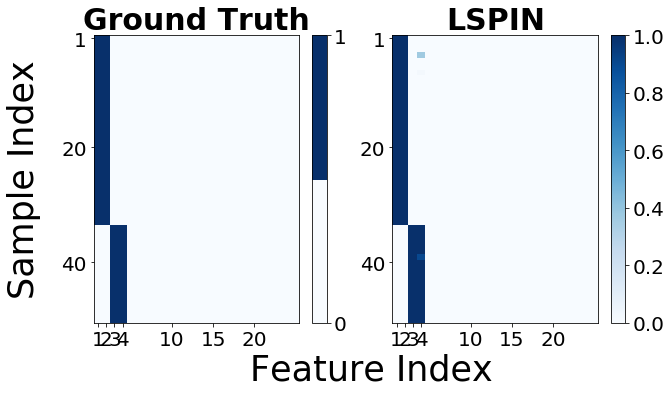

In [26]:
fig, axes = plt.subplots(1, 2, sharex=True,sharey=False,figsize=(10,6))

fig.add_subplot(111, frameon=False)

matplotlib.rc('xtick', labelsize=xtick_size) 

g_test_label = 1*(g_test[:,2] == 1)
sorted_order_test = np.concatenate((np.where(g_test_label == 0)[0],np.where(g_test_label == 1)[0]))

im1 = axes[0].imshow(g_test[sorted_order_test,:25],aspect='auto',cmap=cmap, norm=norm)
axes[0].set_title("Ground Truth",fontsize=title_size,fontweight="bold")
axes[0].set_ylabel("Sample Index",fontsize=ylabel_size,labelpad=20)
axes[0].set_xticks([0,1,2,3,9,14,19])
axes[0].set_xticklabels([1,2,3,4,10,15,20],fontsize=xtick_size)
axes[0].set_yticks([0,19,39])
axes[0].set_yticklabels([1,20,40],fontsize=ytick_size)

im2 = axes[1].imshow(gate_mat_nonl_test[sorted_order_test,:25],aspect='auto',cmap=cmap)
axes[1].set_title("LSPIN",fontsize=title_size,fontweight="bold")
axes[1].set_yticks([0,19,39])
axes[1].set_yticklabels([1,20,40],fontsize=ytick_size)

cbar = fig.colorbar(im1,ax=axes[0], cmap=cmap, norm=norm, boundaries=bounds, ticks=[0, 1])
cbar.ax.tick_params(labelsize=bar_label_size)
cbar = fig.colorbar(im2,ax=axes[1])
cbar.ax.tick_params(labelsize=bar_label_size)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Feature Index",fontsize=xlabel_size)
plt.tight_layout()

In [27]:
### TPR
print("True Positive Rate: {:.4f}".format(np.sum((g_test > 0) & (gate_mat_nonl_test >0))/np.sum(g_test > 0)))

True Positive Rate: 1.0000


In [28]:
### FDR:
print("False Discovery Rate: {:.4f}".format(np.sum((g_test ==0)&(gate_mat_nonl_test >0))/np.sum(gate_mat_nonl_test >0)))

False Discovery Rate: 0.0196
